## Exploratory Data Analysis
### Import all required Modules

In [ ]:
# importing all required models
from mpl_toolkits.axes_grid1 import ImageGrid
import os,sys,ntpath,fnmatch,shutil,cv2,gc
from numpy import asarray,zeros,moveaxis
import joblib,time,os.path,itertools
from sys import getsizeof
from tqdm import tqdm
import numpy as np
import pandas as pd
from os import path
from time import time
np.random.seed(0)
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### File Structures of Dataset

In [ ]:
# Run for File structure
!sudo apt-get install tree
!tree -a "/content/drive/MyDrive/part-1/IDD_Segmentation/"
!tree -a "/content/drive/MyDrive/part-2/idd20kII/"

Streaming output truncated to the last 5000 lines.
    │   ├── 377_frame12008_leftImg8bit.jpg
    │   ├── 377_frame12117_leftImg8bit.jpg
    │   ├── 377_frame12226_leftImg8bit.jpg
    │   ├── 377_frame12362_leftImg8bit.jpg
    │   ├── 377_frame12444_leftImg8bit.jpg
    │   ├── 377_frame12662_leftImg8bit.jpg
    │   ├── 377_frame12799_leftImg8bit.jpg
    │   ├── 377_frame12935_leftImg8bit.jpg
    │   ├── 377_frame13180_leftImg8bit.jpg
    │   ├── 377_frame13344_leftImg8bit.jpg
    │   ├── 377_frame13426_leftImg8bit.jpg
    │   ├── 377_frame13617_leftImg8bit.jpg
    │   ├── 377_frame13917_leftImg8bit.jpg
    │   ├── 377_frame14162_leftImg8bit.jpg
    │   ├── 377_frame14517_leftImg8bit.jpg
    │   ├── 377_frame14735_leftImg8bit.jpg
    │   ├── 377_frame14926_leftImg8bit.jpg
    │   ├── 377_frame15117_leftImg8bit.jpg
    │   ├── 377_frame15226_leftImg8bit.jpg
    │   ├── 377_frame15499_leftImg8bit.jpg
    │   ├── 377_frame15853_leftImg8bit.jpg
    │   ├── 377_frame16126_leftImg8bit.jpg
   

<img src="https://imgur.com/WzmR3W9.png" align="Left">

* The Dataset is available in two parts where each part contains Train, Test, Validation sets of Data.
* The Dataset contains Independent variables and Dependent variables as .png files and .json files respectively 
* JSON files contain Non-overlapping polygons representation of image segments for each Dependent variable.

### File Statistics of each part

In [ ]:
# Fuction to count File
def Count_Files(path):
    """
    Function to count the number of files in a given Directory
    Input   : Folder Path <string>
    Returns : File Count <Integer> 
    """
    # File Traverse through given directory to get file count
    parentFolder,file_count=path,0
    for root, dirs, fileList in os.walk(parentFolder):
        file_count+=len(fileList)
    return file_count

# Dataset Source
root1="/content/drive/MyDrive/part-1/IDD_Segmentation/leftImg8bit/"
root2="/content/drive/MyDrive/part-2/idd20kII/leftImg8bit/"

# print File counts
print("IDD_Segmentation Part-1:")
print("Part1 Train Samples:",Count_Files(root1+"train"))
print("Part1 Val Samples:  ",Count_Files(root1+"val"))
print("Part1 Test Samples: ",Count_Files(root1+"test"))
print("--"*13+"\n"+"--"*13)
print("Idd20kII  Part-2:")
print("Part2 Train Samples:",Count_Files(root2+"train"))
print("Part2 Val Samples:  ",Count_Files(root2+"val"))
print("Part2 Test Samples: ",Count_Files(root2+"test"))
print("--"*13+"\n"+"--"*13)
print("Total Samples:")
print("Total Train Samples:",Count_Files(root1+"train")+Count_Files(root2+"train"))
print("Total Val Samples:  ",Count_Files(root1+"val")+Count_Files(root2+"val"))
print("Total Test Samples: ",Count_Files(root1+"test")+Count_Files(root2+"test"))
print("--"*13)

IDD_Segmentation Part-1:
Part1 Train Samples: 6993
Part1 Val Samples:   981
Part1 Test Samples:  2029
--------------------------
--------------------------
Idd20kII  Part-2:
Part2 Train Samples: 7034
Part2 Val Samples:   1055
Part2 Test Samples:  2009
--------------------------
--------------------------
Total Samples:
Total Train Samples: 14027
Total Val Samples:   2036
Total Test Samples:  4038
--------------------------


* There are Total 14027, 2036, 4038 samples for Train, Validation, and Test respectively 

## Image Data Analysis

In [ ]:
# Function to get Images
def Get_images(path, Grey=False):
    
    """
    This Function returns Images from a given Directory
    Input  : Path <String>, Grey <Boolean>
    Return : Images <list of arrays>
    """
    
    img_files,images=sorted(os.listdir(path)),[] # list names of entries from a given path
    for i in range(len(img_files)):
        if Grey:
            image = cv2.imread(path+img_files[i],cv2.IMREAD_GRAYSCALE) # read image in greyscale by using image reader from opencv
        else:
            image=cv2.cvtColor(cv2.imread(path+img_files[i]),cv2.COLOR_BGR2RGB) # read image and convert it to RGB format 
        images.append(image)
    return images[0] if len(images)==1 else images

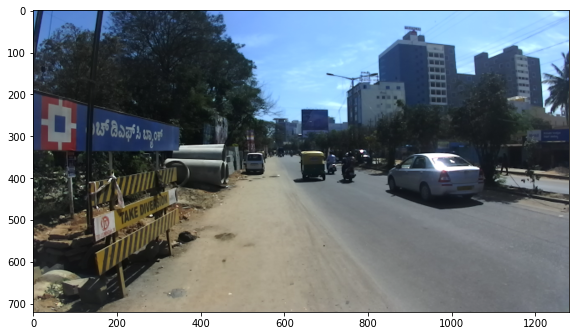

	   RGB Image Shape:  (720, 1280, 3)
	   Red Channel:  Min Value: 0  Max Value: 255 
	 Green Channel:  Min Value: 0  Max Value: 255 
	  Blue Channel:  Min Value: 0  Max Value: 255 


In [ ]:
RGB_Image=Get_images('/content/drive/MyDrive/Random_Samples/image/') # Obtain and plot image 
plt.figure(figsize=(9.6, 6.8))
plt.imshow(RGB_Image)
plt.show()

Channel_Image=np.moveaxis(RGB_Image, -1, 0) # Move axis (channels) and print image info
print("\t   RGB Image Shape: ",RGB_Image.shape)
print("\t   Red Channel:  Min Value: {0}  Max Value: {1} ".format(min(Channel_Image[0].ravel()), max(Channel_Image[0].ravel())))
print("\t Green Channel:  Min Value: {0}  Max Value: {1} ".format(min(Channel_Image[1].ravel()), max(Channel_Image[1].ravel())))
print("\t  Blue Channel:  Min Value: {0}  Max Value: {1} ".format(min(Channel_Image[2].ravel()), max(Channel_Image[2].ravel())))

* The Image contain 3 channels Red, Green and Blue with Resolution 1080x1920 (Height, Width).
* Images are stored in computer as pixels in which each pixel represent intensity. 
* Red, Green, and Blue intensity values all together are used to decide the color of a pixel
* Each pixels is represented by a vector of three(channels) where each contain values in the Range of 0 to 255.

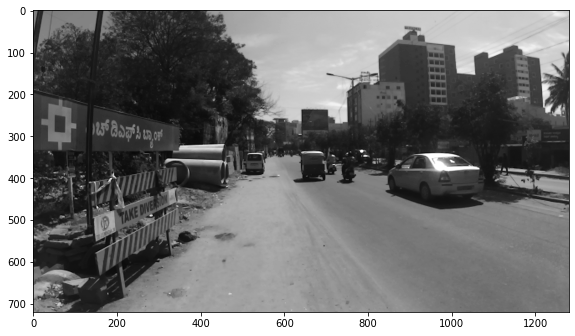

     Gray Scale Image Shape:  (720, 1280)
     Gray Scale:  Min Value: 0  Max Value: 255 


In [ ]:
# Obtain and plot GrayScale Image (GrayScale = 0.2125 R + 0.7154 G + 0.0721 B)
Gray_Scale_Image=Get_images('/content/drive/MyDrive/Random_Samples/image/',True)
plt.figure(figsize=(9.6, 6.8))
plt.imshow(Gray_Scale_Image, cmap='gray')
plt.show()

# Print image info
print(" "*5+"Gray Scale Image Shape: ",Gray_Scale_Image.shape)
print(" "*5+"Gray Scale:  Min Value: {0}  Max Value: {1} ".format(min(Gray_Scale_Image.ravel()), max(Channel_Image.ravel())))

* Greyscale image is one in which the value in each pixel represents intensity information.
* Greyscale image above has resolution 1080x1920 and contains each pixel value between 0 to 255. 

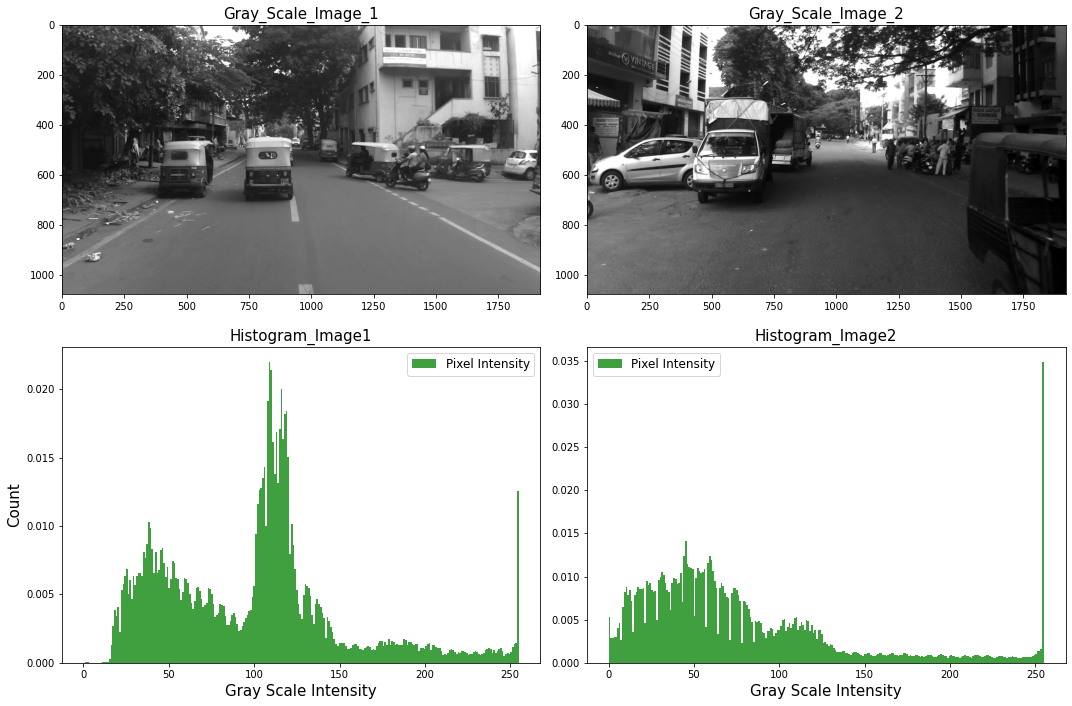

In [ ]:
#ref: https://matplotlib.org/1.2.1/examples/pylab_examples/histogram_demo.html

# Obtain images to plot GreyScale histogram
images=Get_images('/content/drive/MyDrive/Random_Samples/Gray_Hist/',True)

# plot Pixel Intensity by Sub_plot
figure, loc_ind = plt.subplots(2, 2,figsize=(15,10))
image1,image2,fontsize=images[0],images[1],15

# subplot Grayscale image1
loc_ind[0,0].imshow(image1, cmap='gray')
loc_ind[0,0].set_title('Gray_Scale_Image_1',fontsize=fontsize)

# subplot Grayscale image2
loc_ind[0,1].imshow(image2, cmap='gray')
loc_ind[0,1].set_title('Gray_Scale_Image_2',fontsize=fontsize)

# subplot Histogram image1
loc_ind[1,0].hist(image1.ravel(), 256, density=1, color='green', alpha=0.75)
loc_ind[1,0].legend(['Pixel Intensity'],prop={'size': 12})
loc_ind[1,0].set_xlabel('Gray Scale Intensity',fontsize=fontsize)
loc_ind[1,0].set_ylabel('Count',fontsize=fontsize)
loc_ind[1,0].set_title('Histogram_Image1',fontsize=fontsize)

# subplot Histogram image2
loc_ind[1,1].hist(image2.ravel(), 256, density=1, color='green', alpha=0.75)
loc_ind[1,1].legend(['Pixel Intensity'],prop={'size': 12})
loc_ind[1,1].set_xlabel('Gray Scale Intensity',fontsize=fontsize)
loc_ind[1,1].set_title('Histogram_Image2',fontsize=fontsize)

plt.tight_layout()
plt.show()

* The above Plot represents Histogram for Intensity, where Value 0 is considered as Black and 255, is considered as White.
* The Image-1 Histogram has a variety of Shades for each Pixel hence has Non-Skewed Distribution.
* The Image-2 Histogram has a Right Skewed Distribution as it contains more lighter pixels in the image.

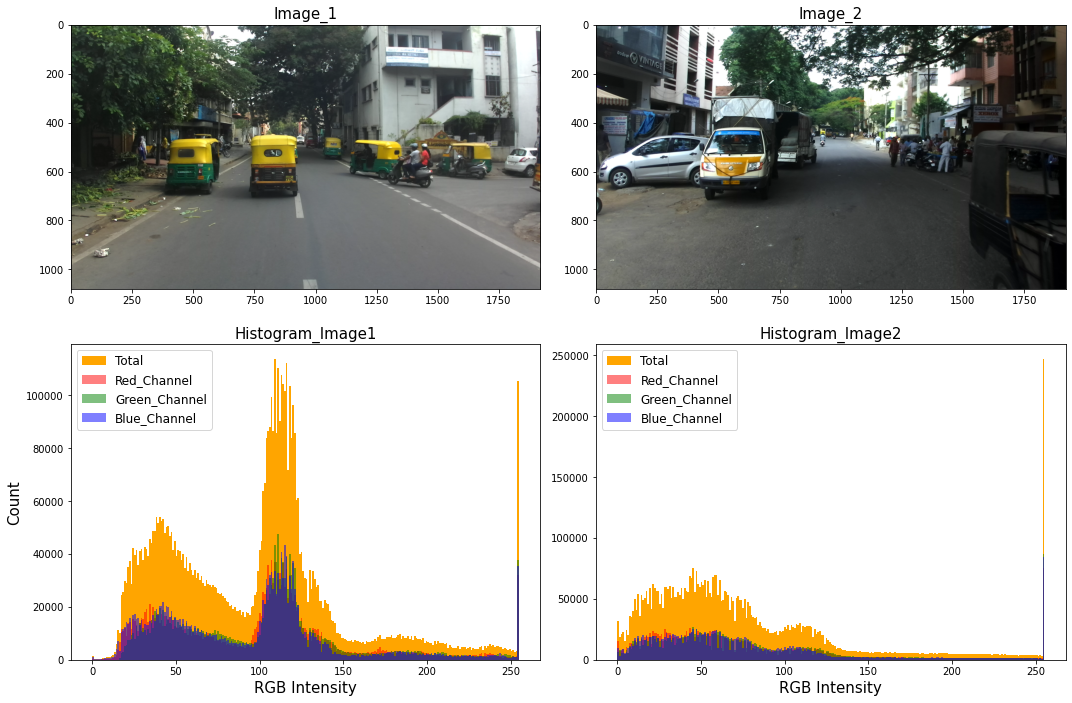

In [ ]:
# Obtain images to plot
images=Get_images('/content/drive/MyDrive/Random_Samples/Color_Hist/')

# plot RGB Pixel Intensity by Sub_plot
figure, loc_ind = plt.subplots(2, 2,figsize=(15,10))
image1,image2,fontsize=images[0],images[1],15

# subplot RGB image1
loc_ind[0,0].imshow(image1)
loc_ind[0,0].set_title('Image_1',fontsize=fontsize)

# subplot RGB image2
loc_ind[0,1].imshow(image2)
loc_ind[0,1].set_title('Image_2',fontsize=fontsize)

# subplot RGB Histogram image1
loc_ind[1,0].hist(image1.ravel(), bins = 256, color = 'orange')
loc_ind[1,0].hist(image1[:, :, 0].ravel(), bins = 256, color = 'red', alpha = 0.5)
loc_ind[1,0].hist(image1[:, :, 1].ravel(), bins = 256, color = 'Green', alpha = 0.5)
loc_ind[1,0].hist(image1[:, :, 2].ravel(), bins = 256, color = 'Blue', alpha = 0.5)
loc_ind[1,0].legend(['Total', 'Red_Channel', 'Green_Channel', 'Blue_Channel'],prop={'size': 12})
loc_ind[1,0].set_xlabel('RGB Intensity',fontsize=fontsize)
loc_ind[1,0].set_ylabel('Count',fontsize=fontsize)
loc_ind[1,0].set_title('Histogram_Image1',fontsize=fontsize)

# subplot RGB Histogram image2
loc_ind[1,1].hist(image2.ravel(), bins = 256, color = 'orange')
loc_ind[1,1].hist(image2[:, :, 0].ravel(), bins = 256, color = 'red', alpha = 0.5)
loc_ind[1,1].hist(image2[:, :, 1].ravel(), bins = 256, color = 'Green', alpha = 0.5)
loc_ind[1,1].hist(image2[:, :, 2].ravel(), bins = 256, color = 'Blue', alpha = 0.5)
loc_ind[1,1].legend(['Total', 'Red_Channel', 'Green_Channel', 'Blue_Channel'],prop={'size': 12})
loc_ind[1,1].set_xlabel('RGB Intensity',fontsize=fontsize)
loc_ind[1,1].set_title('Histogram_Image2',fontsize=fontsize)

plt.tight_layout()
plt.show()

* The Above Histogram represents the Red, Blue, Green intensities in the Image for each pixel.
* Image-1 Histogram has more Blue intensity values than other color intensity.
* Image-2 Histogram has more contrast hence it is skewed for all intensities.

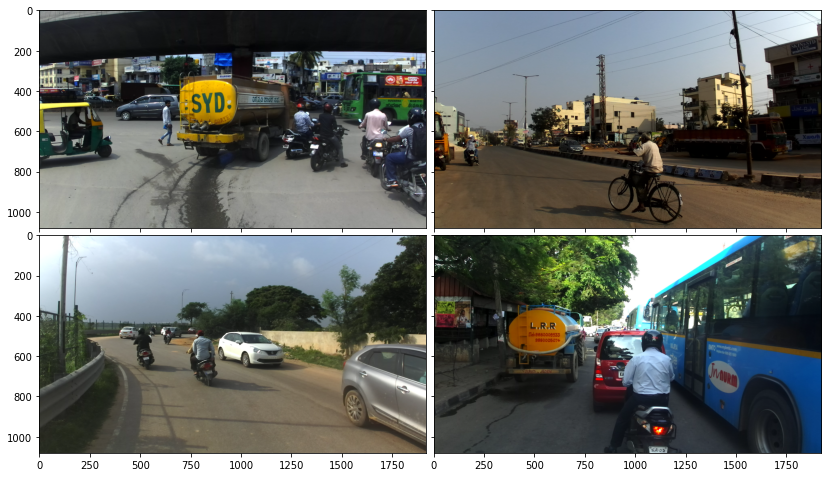

In [ ]:
# ploting random images with ImageGrid
# ref:https://matplotlib.org/3.1.1/gallery/axes_grid1/simple_axesgrid.html
fig = plt.figure(figsize=(14, 14))
grid = ImageGrid(fig, 111,  nrows_ncols=(2, 2),axes_pad=0.1)
images=Get_images('/content/drive/MyDrive/Random_Samples/Grid/')
for ax, i in zip(grid, [images[0], images[1], images[2], images[3]]):
    ax.imshow(i)
plt.show()

* The Above images has a mix of urban and rural Roads with a variety of traffic and with large diversity.
* Data contain a variety of vehicles and high density of motorcycle.
* Image contains Unpredictable Road Scene where a herd of buffaloes on the road.

## Generating Labels and Simplifying File structure

In [ ]:
# Installing required packages
!pip install numpngw scipy==1.1.0 imgaug==0.2.6 pillow>=4.3.0
from IPython.display import clear_output
clear_output(wait=True)

# Function to Generate Mask
def Generate_Labels_Mask(string_path,image_set):
    
    '''
    -----------------------------------------------------------
    Function Generates Label mask for all JSON files and simplify File structure
        1. Rename all files with a new prefix for each filename.   
        2. Generate Label mask for all file   
        3. Re-organize Label mask to a single folder of each set 
        4. Remove Unwanted files after Obtaining Labels     
    -----------------------------------------------------------
        Parameters
        ----------
        String_path <Path>    : Absolute Path of all Data files.
        Image_set <Integer>   : Image_set which can be 1 or 2 
    
        returns 
        --------
        Boolean<True>  : Indicate successful Label Generation 
    -----------------------------------------------------------

    '''
    
    # Rename all file with file's folder_name as prefix
    parentFolder=string_path
    for dirName, subdirs, fileList in os.walk(parentFolder):    
        for filename in fileList:
            path = os.path.join(dirName, filename)
            os.rename(path,"{}/{}_{}".format(dirName,ntpath.basename(dirName),ntpath.basename(filename)))

    # Label Mask generation for given image_set
    if image_set==1:
        !python "/content/drive/MyDrive/public-code-master/preperation/createLabels.py" --datadir "/content/drive/MyDrive/part-1/IDD_Segmentation" --id-type level1Id --color True --num-workers 2
    elif image_set==2:
        !python "/content/drive/MyDrive/public-code-master/preperation/createLabels.py" --datadir "/content/drive/MyDrive/part-2/idd20kII" --id-type level1Id --color True --num-workers 2

    # clear output Screen
    clear_output(wait=True)
    
    # Re-Organize files for each set to a single folder 
    def Organize_Labels(id_level):
        pattern,partial_dir='*level1Ids.png',"_label_level1"
        
        # Group files to corresponding train or val set
        def Group_Files(dirPath, pattern):
            for parentDir, dirnames, filenames in os.walk(dirPath):
                for filename in fnmatch.filter(filenames, pattern):
                    shutil.move(os.path.join(parentDir, filename), r"{}{}/{}".format(dirPath,partial_dir,filename))
            return True
        
        # Make new Directory to Organize train Files
        os.mkdir(string_path+"/gtFine/train"+partial_dir)
        return_val = Group_Files(string_path+'/gtFine/train', pattern)
        
        # Make new Directory to Organize val Files
        os.mkdir(string_path+"/gtFine/val"+partial_dir)
        return_val = Group_Files(string_path+'/gtFine/val', pattern)
        
        return True

    # Invoke Organize_Labels for Level1
    indicator=Organize_Labels(id_level=1)

    # Function to remove unwanted Files and Folders after mask generation
    def RemoveUnwantedFiles(dirPath, pattern):
        for parentDir, dirnames, filenames in os.walk(dirPath):
            for filename in fnmatch.filter(filenames, pattern):
                shutil.move(os.path.join(parentDir, filename), dirPath+"/"+filename)
            if len(os.listdir(parentDir)) == 0:
                os.rmdir(parentDir)
        return  True
    
    # Invoke RemoveUnwantedFiles for Image_set1
    if image_set==1:
        indicator = RemoveUnwantedFiles(string_path+'/leftImg8bit/train', "*.png")
        indicator = RemoveUnwantedFiles(string_path+'/leftImg8bit/val', "*.png")
        indicator = RemoveUnwantedFiles(string_path+'/leftImg8bit/test', "*.png")
    
    # Invoke RemoveUnwantedFiles for Image_set2
    elif image_set==2:
        indicator = RemoveUnwantedFiles(string_path+'/leftImg8bit/train', "*.jpg")
        indicator = RemoveUnwantedFiles(string_path+'/leftImg8bit/val', "*.jpg")
        indicator = RemoveUnwantedFiles(string_path+'/leftImg8bit/test', "*.jpg")
    print("Label generation successful for Image_Set part{} Done".format(image_set))

    return True

# Execute only for Direct Invoke 
if __name__ == "__main__": 
    res=Generate_Labels_Mask("/content/drive/MyDrive/part-1/IDD_Segmentation",1)
    res=Generate_Labels_Mask("/content/drive/MyDrive/part-2/idd20kII",2)

FileExistsError: ignored

### Simplified File Structure of Dataset

<img src="https://imgur.com/BX2Y1qq.png" align="Left">

* After Mask Generation, Dataset contains the same number of files except for each JSON file there is a corresponding Label Mask Image.
* As represented above Data is available in two parts each with Train, Test, Validation sets which contain both Images and Label mask.

In [ ]:
# compute Dataset Total size
root,total_files='/content/drive/MyDrive/',0
def get_size(start_path):
    
    """
    Function to compute each file size in each directory
    input  <String>  : Directory Path
    Return <Float>   : Total Size of Data
    """
    
    global total_files
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(start_path):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            if not os.path.islink(fp):
                total_files+=1
                total_size += os.path.getsize(fp)
    return total_size

# Invoke get_size()
total_size=get_size(root+'part-2/idd20kII')+get_size(root+'part-1/IDD_Segmentation')
print("After Mask Generation")
print("Total Numbers of Files:",total_files)
print("Total size of Data on Disk: {} GB".format(np.round(total_size/1000**3,2)))

After Mask Generation
Total Numbers of Files: 36164
Total size of Data on Disk: 26.71 GB


## Label Analysis and Hierarchy
### <u>Class Pixel Distribution for Datasets</u>

<img src="https://imgur.com/g9mWvIO.png" align="Left">

* The Label hierarchy consists of 4 levels as above having 7 (level 1), 16 (level 2), 26 (level 3), and 30 (level 4) labels. 
* There are a very few image samples which include a tunnel, trailer, rail track, and vehicles, Roadside objects appear more common in each sample. 
* This Case study aims to solve for only Level-1 as in Label hierarchy due to the limit of Hardware Resources.
* Dataset looks to be well Balanced with almost a uniform Distribution except for some classes.

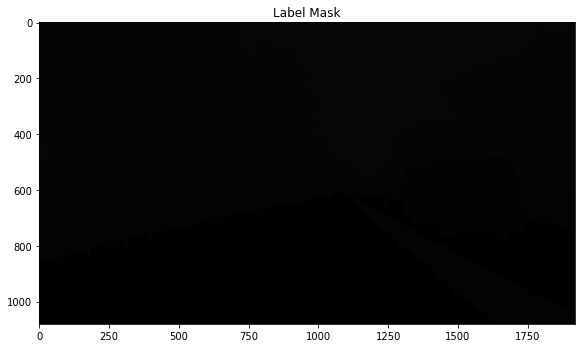

Label Mask Shape: (1080, 1920)

Unique Class Labels in Mask: {0, 1, 2, 3, 4, 5, 6}

Class Value Count: {0: 576222, 1: 30192, 2: 607, 3: 111393, 4: 242870, 5: 783749, 6: 328538}


In [ ]:
# Get and plot label mask
plt.figure(figsize=(9.6, 6.8))
Label_Mask=Get_images('E:/Colab Notebooks/Random_Samples/Count/',True)
plt.imshow(Label_Mask, cmap='gray')
plt.title("Label Mask")
plt.show()
print("Label Mask Shape:",Label_Mask.shape)

# compute Value Count of each pixel
Label_Mask=[i for i in Label_Mask.ravel() if i != 255]
(unique, counts) = np.unique(Label_Mask, return_counts=True)
Value_count= dict(zip(unique, counts))
print("\nUnique Class Labels in Mask:",set(Label_Mask))
print("\nClass Value Count:",Value_count)

* The Label Mask contain has a Resolution of 1080x1920 (Height, Width).
* Each pixel in Label Mask has values in the Range of 0 to 6 for Label_Level1
* The Label Mask has to color-coded to do some and analysis

## Color code Label Mask and Visualization

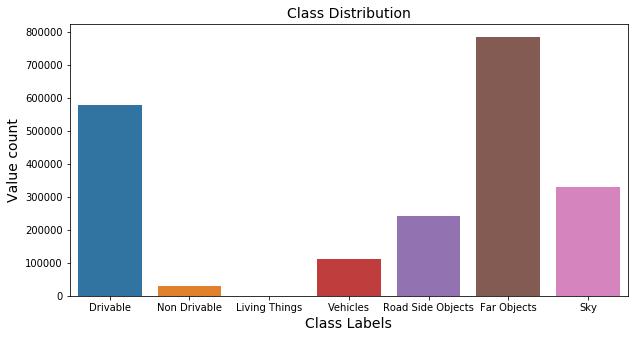

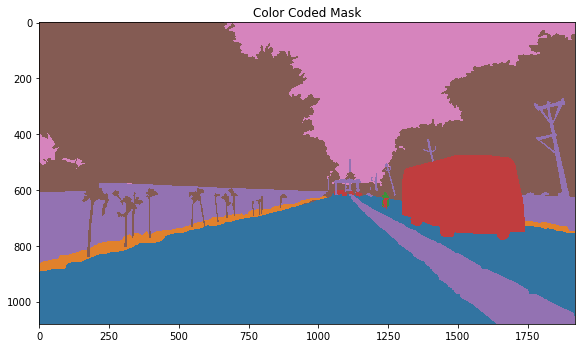

Class Label Mapping:
 {'Drivable': 0, 'Non Drivable': 1, 'Living Things': 2, 'Vehicles': 3, 'Road Side Objects': 4, 'Far Objects': 5, 'Sky': 6}


In [ ]:
def Color_code_label(label_image, sns_code=False):
    
    """
    Function to color code a given Label Mask
    input  : Mask<Array>,  Boolean(Indicator of color scheme)
    return : color coded Mask <Array>
    """
    
    # Switch axis of Mask
    cf_label_image=np.moveaxis(label_image, -1, 0)
    
    # preparing color mappings
    if sns_code:
        color_code=[[50, 116, 161],[225, 129, 44],[58, 146, 58],[192, 61, 62],[147, 114, 178],[132, 91, 83],[214, 132, 189],[105, 143, 35]]
    else :
        color_code=[[130, 62, 130],[230, 150, 141],[254, 0, 0],[0, 0, 140],[153, 153, 153],[151, 120, 91],[69, 130, 179],[105, 143, 35]]
    
    # change value in each pixel to a specific color 
    m, n= cf_label_image.shape[1], cf_label_image.shape[2]
    for k in range(3):
        for i in range(m):
            for j in range(n):
                index=7 if int(cf_label_image[k][i][j])==255 else int(cf_label_image[k][i][j])
                cf_label_image[k][i][j]=color_code[index][k]
    
    # Switch back axis of color-coded Mask
    cf_label_image=np.moveaxis(cf_label_image, 0, -1)
    return cf_label_image

# plot class Distribution for a Mask
import seaborn as sns
plt.figure(figsize=(10, 5))
label=['Drivable', 'Non Drivable', 'Living Things', 'Vehicles', 'Road Side Objects', 'Far Objects', 'Sky']
Mask_Data = pd.DataFrame({'Value count': counts, 'Class Labels': label})
fig = sns.barplot(x = 'Class Labels', y = 'Value count', data = Mask_Data)
plt.xlabel("Class Labels",fontsize=14)
plt.ylabel("Value count",fontsize=14)
plt.title("Class Distribution",fontsize=14)
plt.show()

# visualize a color-coded Mask 
plot_mask=Get_images('E:/Colab Notebooks/Random_Samples/Count/')
cf_label_image=Color_code_label(plot_mask,True)
plt.figure(figsize=(9.6, 6.8))
plt.title("Color Coded Mask")
plt.imshow(cf_label_image)
plt.show()

# printing Class value Mapping
Label_Mapping={"Drivable":0,"Non Drivable":1,"Living Things":2,"Vehicles":3,"Road Side Objects":4,"Far Objects":5,"Sky":6}
print("Class Label Mapping:\n",Label_Mapping)

* The Label Mask contains more Far objects and very few Living things.
* The class Pixels in this Label Mask is slightly imbalanced as above

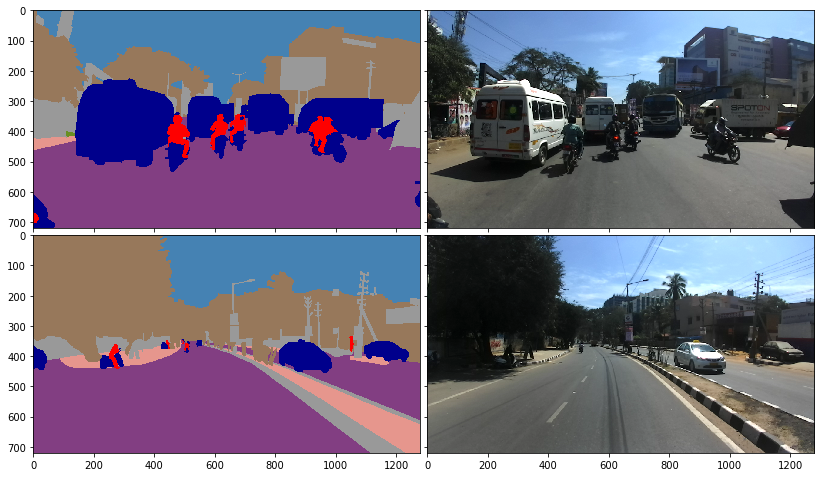

In [ ]:
# visualization of some color-coded label mask with ImageGrid
label_images=Get_images('E:/Colab Notebooks/Random_Samples/Labels/')
fig = plt.figure(figsize=(14, 14))
grid = ImageGrid(fig, 111,  nrows_ncols=(2, 2),axes_pad=0.1)
for ax, i in zip(grid, [Color_code_label(label_images[0]), label_images[1], Color_code_label(label_images[2]), label_images[3]]):
    ax.imshow(i)
plt.show()